In [1]:
import pandas as pd
import numpy as np
import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('final_project_data.csv', parse_dates = True, index_col = 0)

In [3]:
df.head()

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115
1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825
1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573
1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005
1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330


 - United States and UK Interest Rates: These are the 3-Month or 90-day Rates and Yields
 - United States and UK Unemployment  Rates: This is the harmonized Unemployment Rate: Total: All Persons for each country. Note that the date is shifted by one month to reduce the impact of lookahead bias (ideally we would precisely line up the release dates for each country). 
 - United States and UK Unemployment  Rates: This is the YoY percent change in the CPI for each country. Note that the date is shifted by one month to reduce the impact of lookahead bias (ideally we would precisely line up the release dates for each country).
 - GBPUSD: U.S. Dollars to U.K. Pound Sterling Spot Exchange Rate (DEXUSUK)

In [4]:
df.columns

Index(['United States Interest', 'United Kingdom Interest',
       'United States Inflation', 'United Kingdom Inflation',
       'United States Unemployment', 'United Kingdom Unemployment', 'DEXUSUK'],
      dtype='object')

In [5]:
data = df.rename(columns = {'United States Interest':'I_US', 'United Kingdom Interest':'I_UK', 
                             'United States Inflation':'Inf_US', 'United Kingdom Inflation':'Inf_UK',
                             'United States Unemployment':'Une_US', 'United Kingdom Unemployment':'Une_UK', 
                             'DEXUSUK':'EX'})
data.head()

,I_US,I_UK,Inf_US,Inf_UK,Une_US,Une_UK,EX
1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115
1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825
1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573
1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005
1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330


### Try1: Kalman Filter

#### Data

In [6]:
data_KF = data[['I_US', 'I_UK', 'EX']]
data_KF.head()

,I_US,I_UK,EX
1983-02-01,8.54,11.3338,1.5115
1983-03-01,8.69,10.9757,1.4825
1983-04-01,8.63,10.2616,1.5573
1983-05-01,8.49,10.2593,1.6005
1983-06-01,9.20,9.9384,1.5330


In [7]:
# IRD
def scale(x):
    return (x - x.min()) / (x.max() - x.min())

data_KF['ir_diff'] = scale(data_KF['I_US']) - scale(data_KF['I_UK'])

In [8]:
train_size = int(len(data)*0.8)
train_KF, test_KF = data_KF[0:train_size], data_KF[train_size:]

#### Trading Strategy

In [9]:
def trading_strategy_KF(data, k, w, z, i):
    temp_KF = data.copy()
    temp_KF['Filter'] = temp_KF.ir_diff.ewm(alpha = k, adjust = False).mean()
    temp_KF['Filter Error'] = temp_KF.ir_diff - temp_KF['Filter']
    temp_KF['std'] = temp_KF['Filter Error'].rolling(w).std()
    temp_KF['upper'] = temp_KF['Filter'] + z*temp_KF['std']
    temp_KF['lower'] = temp_KF['Filter'] - z*temp_KF['std']
    temp_KF['test'] = np.where(temp_KF['Filter Error'].abs() > z*temp_KF['std'], -1, 0)*np.sign(temp_KF['Filter Error'])
    
    drange_end = (temp_KF.index[-1] + pd.DateOffset(months = ((i-1)//30 + 1))).strftime('%m/%d/%Y')
    drange = pd.date_range(start = temp_KF.index[0], end = drange_end)
    temp_KF_daily = pd.DataFrame(index = drange)
    temp_KF_daily[['test', 'upper', 'lower', 'Filter', 'ir_diff']] = temp_KF[['test', 'upper', 'lower', 'Filter', 'ir_diff']]
    temp_KF_daily[['upper', 'lower', 'Filter', 'ir_diff']]= temp_KF_daily[['upper', 'lower', 'Filter', 'ir_diff']].ffill()
    temp_KF_daily.fillna(0, inplace = True)
    
    temp_KF_daily.loc[:, str(i) + '_signal'] = 0
    for j in temp_KF_daily.index:
        if temp_KF_daily.loc[j, 'test'] != 0:
            temp_KF_daily.loc[j : j + pd.Timedelta(days=i),str(i) + '_signal'] = temp_KF_daily.loc[j,'test']

    
    exrate = pd.DataFrame(index = drange)        
    exrate['EX'] = temp_KF['EX']
    exrate['EX']  = exrate['EX'].ffill()
    temp_KF_daily['EX'] = exrate['EX']
    temp_KF_daily['returns'] = np.log(temp_KF_daily['EX']).diff()
    temp_KF_daily[str(i) + '_Return'] = np.exp((temp_KF_daily[str(i) + '_signal'].shift() * temp_KF_daily.returns).cumsum()) - 1
    
    return temp_KF_daily[str(i) + '_Return'][-1], temp_KF_daily


In [10]:
trading_strategy_KF(data_KF, k=0.1, w=10, z=0, i=50)[0]

0.9028685249407098

#### Optimize

In [11]:
import itertools
k_values = np.linspace(.001, .05, 10)
w_values = np.arange(0, 20, 5)
z_values = np.arange(0, 2, .4)
i_values = np.arange(30, 60, 5)
grid = list(itertools.product(k_values, w_values, z_values, i_values))
storage = pd.DataFrame(columns = ['k', 'z','w', 'i', 'profits'])

In [12]:
for k, w, z, i in grid:
    metric = trading_strategy_KF(train_KF, k, w, z, i)[0]
    storage = storage.append({'k':k, 'z':z, 'w':w, 'i':i, 'profits':metric}, ignore_index = True)

In [13]:
storage.sort_values(by = 'profits', ascending = False).head(50)

,k,z,w,i,profits
395,0.017333,0.0,5.0,55.0,1.71381
390,0.017333,0.0,5.0,30.0,1.71381
391,0.017333,0.0,5.0,35.0,1.71381
392,0.017333,0.0,5.0,40.0,1.71381
393,0.017333,0.0,5.0,45.0,1.71381
394,0.017333,0.0,5.0,50.0,1.71381
270,0.011889,0.0,5.0,30.0,1.623349
272,0.011889,0.0,5.0,40.0,1.623349
273,0.011889,0.0,5.0,45.0,1.623349
274,0.011889,0.0,5.0,50.0,1.623349


#### Heatmap

In [14]:
def heatmap(x, y, metric, values):
    p2p = values[[x, y, metric]]
    heat = np.round(p2p.groupby([x,y]).max(),1)
    heat = heat.unstack()[metric]

    heat.index = np.round(heat.index, 2)
    heat.columns = np.round(heat.columns, 2)

    f, ax = plt.subplots(figsize = (25,12))
    ax = sns.heatmap(heat, fmt = '.1g')
    ax.set_title('Heat map of ' + metric, size = 18)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale = 1)
    plt.show()

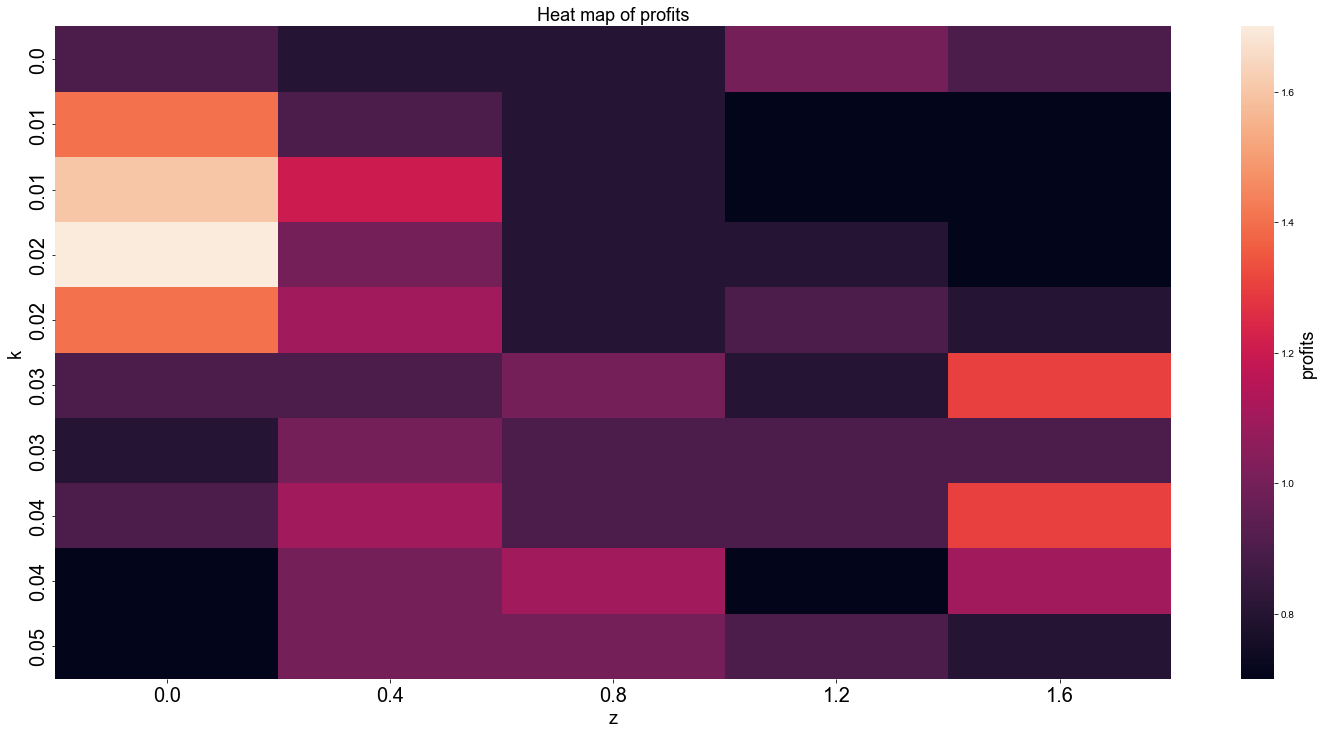

In [15]:
heatmap('k', 'z', 'profits', storage)

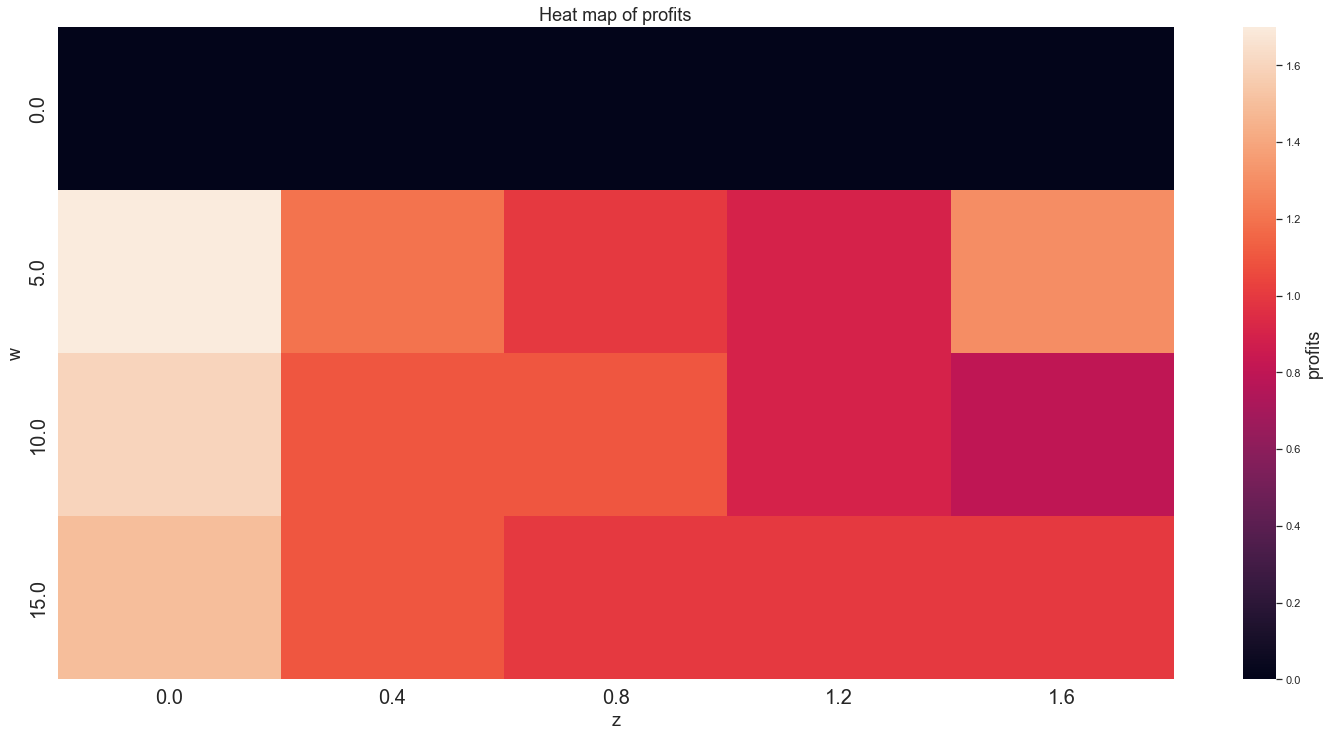

In [16]:
heatmap('w', 'z', 'profits', storage)

#### Test Strategy

In [17]:
k_best = 0.017333
z_best = 0
w_best = 5
i_best = 50
metric_test_KF, test_KF_daily  = trading_strategy_KF(test_KF, k = k_best, w = w_best, z = z_best, i = i_best)
metric_test_KF

0.3145922458601016

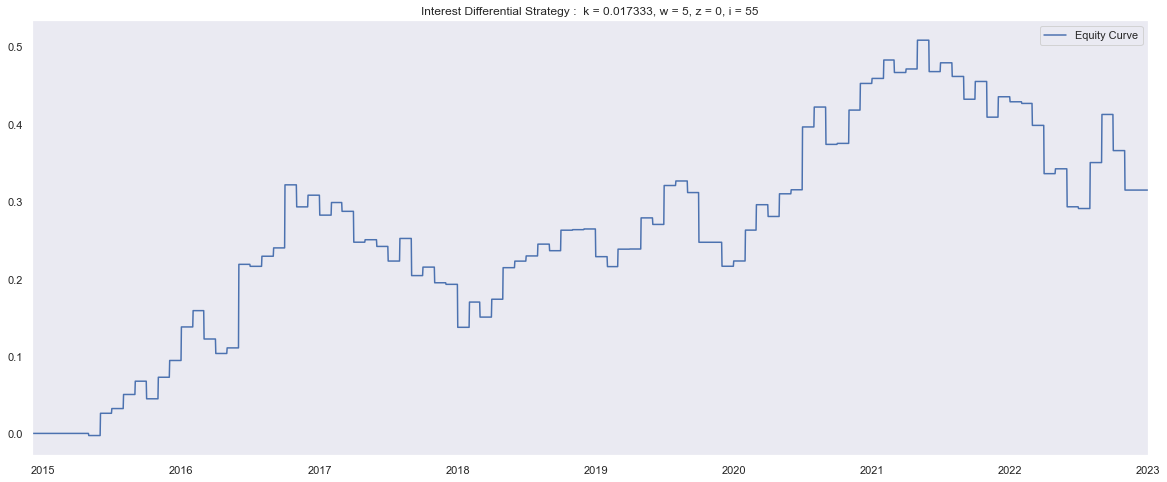

In [18]:
# Equity Curve
plt.figure(figsize = (20,8))
(test_KF_daily[str(i_best) + '_Return'].dropna()).plot()
plt.title('Interest Differential Strategy : ' + ' k = ' + str(k_best) + ', w = ' + str(w_best) + ', z = ' + str(z_best)+ ', i = ' + str(i))
plt.legend(['Equity Curve'])
plt.grid()

#### Binomial Test

In [19]:
df_BT = test_KF_daily[test_KF_daily.test != 0][[str(i_best) + '_signal', 'EX']].copy()
df_BT['D'] = df_BT[str(i_best) + '_signal']
df_BT = df_BT[:-2].copy()
df_BT['s_current'] = test_KF_daily[test_KF_daily.index.isin(df_BT.index)]['EX'].values 
df_BT['s_future'] = test_KF_daily[test_KF_daily.index.isin(df_BT.index + datetime.timedelta(i_best))]['EX'].values
df_BT['R'] = np.where(df_BT['s_future'] >= df_BT['s_current'], 1, -1) 
df_BT['W'] = (df_BT['D'] - np.mean(df_BT['D']))*(df_BT['R'] - np.mean(df_BT['R']))
T_B = np.mean(df_BT['W']) 

dy = df_BT['W'] - np.mean(df_BT['W'])
gamma_0 = sum((dy)**2)/len(df_BT)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df_BT)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

# Binomial Test
statistic = T_B / np.sqrt(LRV / df_BT.shape[0])

In [20]:
statistic
# reject the null hypothesis at 10% level

1.2900584248779574

#### HFRI Metrics: why

1. Risk/Return

In [21]:
test_KF_daily

,test,upper,lower,Filter,ir_diff,50_signal,EX,returns,50_Return
2014-12-01,0.0,0.000000,0.000000,-0.027543,-0.027543,0,1.5578,NaN,NaN
2014-12-02,0.0,0.000000,0.000000,-0.027543,-0.027543,0,1.5578,0.0,0.000000
2014-12-03,0.0,0.000000,0.000000,-0.027543,-0.027543,0,1.5578,0.0,0.000000
2014-12-04,0.0,0.000000,0.000000,-0.027543,-0.027543,0,1.5578,0.0,0.000000
2014-12-05,0.0,0.000000,0.000000,-0.027543,-0.027543,0,1.5578,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2022-12-28,0.0,0.037068,0.037068,0.037068,0.152230,0,1.1962,0.0,0.314592
2022-12-29,0.0,0.037068,0.037068,0.037068,0.152230,0,1.1962,0.0,0.314592
2022-12-30,0.0,0.037068,0.037068,0.037068,0.152230,0,1.1962,0.0,0.314592
2022-12-31,0.0,0.037068,0.037068,0.037068,0.152230,0,1.1962,0.0,0.314592


In [24]:
# Resample back to monthly returns
test_KF_daily['strategy_returns'] = np.exp(test_KF_daily[str(i_best) + '_signal'].shift() * test_KF_daily.returns) - 1
test_KF_mon = (test_KF_daily[['strategy_returns']]+1).resample('m').prod()-1

# Monthly cumulative returns
test_KF_mon[str(i_best) + '_Return'] = test_KF_daily[[str(i_best) + '_Return']].resample('m').mean()

test_KF_mon

,strategy_returns,50_Return
2014-12-31,0.000000,0.000000
2015-01-31,0.000000,0.000000
2015-02-28,0.000000,0.000000
2015-03-31,0.000000,0.000000
2015-04-30,0.000000,0.000000
...,...,...
2022-09-30,0.046075,0.412354
2022-10-31,-0.033087,0.365623
2022-11-30,-0.037368,0.314592
2022-12-31,0.000000,0.314592


In [30]:
# Calculate the geometric average of monthly returns
num_mon_KF = len(test_KF_mon)

gam_KF_1 = (1+test_KF_mon[str(i_best) + '_Return'][-1])**(1/num_mon_KF) - 1
gam_KF_2 = (1+test_KF_mon['strategy_returns']).prod()**(1/num_mon_KF) - 1

(gam_KF_1, gam_KF_2)

(0.0027949858360765134, 0.0027949858360765134)

In [31]:
# Calculate the std. Deviation
std_KF = test_KF_mon['strategy_returns'].std()

std_KF

0.025021592585452106

In [32]:
# Get the High and Low of monthly returns
high_mon_KF = test_KF_mon['strategy_returns'].max()*100
low_mon_KF = test_KF_mon['strategy_returns'].min()*100

(high_mon_KF, low_mon_KF)

(9.72662739767407, -4.899914985702147)

In [33]:
# Calculate Annualized Return
RoR_A_KF = (1+test_KF_mon[str(i_best) + '_Return'][-1])**(1/(num_mon_KF/12)) - 1

100*RoR_A_KF

3.4060252342086095

In [35]:
# Get the Risk-free rate
## Load the 1-year-treasury-rate-yield-chart.csv
treasury = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()

## Get the monthly risk-free rates
rf_mon = (treasury/100+1)**(1/12) - 1
test_KF_mon['rf_mon'] = rf_mon
test_KF_mon['rf_mon'] = test_KF_mon['rf_mon'].ffill()

## Get the yearly risk-free rates
test_KF_mon['rf_yr'] = treasury
test_KF_mon['rf_yr'] = test_KF_mon['rf_yr'].ffill()

test_KF_mon

,strategy_returns,50_Return,rf_mon,rf_yr
2014-12-31,0.000000,0.000000,0.000208,0.25
2015-01-31,0.000000,0.000000,0.000208,0.25
2015-02-28,0.000000,0.000000,0.000208,0.25
2015-03-31,0.000000,0.000000,0.000216,0.26
2015-04-30,0.000000,0.000000,0.000200,0.24
...,...,...,...,...
2022-09-30,0.046075,0.412354,0.003314,4.05
2022-10-31,-0.033087,0.365623,0.003803,4.66
2022-11-30,-0.037368,0.314592,0.003867,4.74
2022-12-31,0.000000,0.314592,0.003867,4.74


In [83]:
# Calculate the sharpe ratio
test_KF_yr = (test_KF_mon[['strategy_returns', 'rf_mon']] + 1).resample('Y'). prod() - 1
test_KF_yr['excess'] = test_KF_yr['strategy_returns'] - test_KF_yr['rf_mon']

annualized_reY_KF = (test_KF_yr['excess'] + 1).prod()**(1/len(test_KF_yr)) - 1
std_reY_KF = test_KF_yr['excess'].std()

sharpe_KF = annualized_reY_KF/std_reY_KF

sharpe_KF

0.1580996778103461

In [98]:
# # Calculate the % of Winning Mo.
# test_KF_daily[str(i_best)+"_success"] = ((test_KF_daily[test_KF_daily.test!= 0][str(i_best)+"_Return"].diff()>0)*1).shift(-1)
# longsuccess_KF = test_KF_daily[(test_KF_daily[str(i_best)+"_success"] == 1) & (test_KF_daily["test"] == 1)]
# shortsuccess_KF = test_KF_daily[(test_KF_daily[str(i_best)+"_success"] == 1) & (test_KF_daily["test"] == -1)]

# lsr_KF = len(longsuccess_KF)/len(test_KF_daily[test_KF_daily.test!= 0]) * 100
# ssr_KF = len(shortsuccess_KF)/len(test_KF_daily[test_KF_daily.test!= 0]) * 100

# (lsr_KF, ssr_KF)

(16.304347826086957, 40.21739130434783)

In [99]:
# Calculate the % of Winning Mo.
sr_KF = len(test_KF_mon[test_KF_mon['strategy_returns'] > 0])/len(test_KF_mon)
sr_KF

0.5306122448979592

In [106]:
# Calculate the max drawdown
running_max_KF = (1+test_KF_mon[str(i_best) + '_Return']).cummax()
drawdown_KF = (1 + test_KF_mon[str(i_best) + '_Return'] - running_max_KF) / running_max_KF
max_drawdown_KF = drawdown_KF[drawdown_KF != -np.inf].min()

max_drawdown_KF*100

-14.427430236955233

2. Regression

In [41]:
import yfinance as yf

In [132]:
# Laod the S&P500 as market return
sp500 = yf.download("^GSPC")[["Adj Close"]]
sp500.index = sp500.index.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


In [133]:
sp500 = sp500.resample('M').last().pct_change()
sp500

,Adj Close
Date,
1927-12-31,NaN
1928-01-31,-0.005096
1928-02-29,-0.017644
1928-03-31,0.117034
1928-04-30,0.024378
...,...
2022-11-30,0.053753
2022-12-31,-0.058971
2023-01-31,0.061753


In [134]:
# Generate the return excess and market excess
test_KF_mon['SP500'] = sp500['Adj Close']
test_KF_mon['returns_excess'] = test_KF_mon['strategy_returns'] - test_KF_mon['rf_mon']
test_KF_mon['market_excess'] = test_KF_mon['SP500'] - test_KF_mon['rf_mon']

In [45]:
import statsmodels.formula.api as smf

In [135]:
# Run the regression
ols_KF = smf.ols('returns_excess ~ market_excess', data=test_KF_mon).fit()
ols_KF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         returns_excess   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.491
Date:                Mon, 13 Mar 2023   Prob (F-statistic):             0.0648
Time:                        14:43:20   Log-Likelihood:                 224.10
No. Observations:                  98   AIC:                            -444.2
Df Residuals:                      96   BIC:                            -439.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0028      0.003      1.093      0.277      -0.002       0.008
market_excess    -0.1026      0.055     -1.868      0.065      -0.212       0.006
==============================================================================
Omnibus:                       10.216   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.573
Skew:                           0.472   Prob(JB):                     0.000685
Kurtosis:                       4.636   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
# Store the alpha and beta
alpha_KF = ols_KF.params[0]
beta_KF = ols_KF.params[1]

(alpha_KF, beta_KF)

(0.002772953704200097, -0.10255161741923877)

In [137]:
# Mnt. R-Squared
R2_KF = ols_KF.rsquared
R2_KF

0.03508662859329592

In [138]:
test_KF_mon

,strategy_returns,50_Return,rf_mon,rf_yr,SP500,returns_excess,market_excess
2014-12-31,0.000000,0.000000,0.000208,0.25,-0.004189,-0.000208,-0.004397
2015-01-31,0.000000,0.000000,0.000208,0.25,-0.031041,-0.000208,-0.031249
2015-02-28,0.000000,0.000000,0.000208,0.25,0.054893,-0.000208,0.054684
2015-03-31,0.000000,0.000000,0.000216,0.26,-0.017396,-0.000216,-0.017613
2015-04-30,0.000000,0.000000,0.000200,0.24,0.008521,-0.000200,0.008321
...,...,...,...,...,...,...,...
2022-09-30,0.046075,0.412354,0.003314,4.05,-0.093396,0.042761,-0.096710
2022-10-31,-0.033087,0.365623,0.003803,4.66,0.079863,-0.036890,0.076061
2022-11-30,-0.037368,0.314592,0.003867,4.74,0.053753,-0.041235,0.049886
2022-12-31,0.000000,0.314592,0.003867,4.74,-0.058971,-0.003867,-0.062838


In [139]:
# Correlation ?
corr_KF = np.corrcoef(test_KF_mon.dropna()['returns_excess'], test_KF_mon.dropna()['market_excess'])[0,1]
corr_KF

-0.18731425090818862

In [140]:
# Up ALpha nad Up Beta and Up R Square
up_mask_KF = test_KF_mon['SP500'] > 0
ols_up_KF = smf.ols('returns_excess ~ market_excess', data=test_KF_mon[up_mask_KF]).fit()
ols_up_KF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         returns_excess   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.621
Date:                Mon, 13 Mar 2023   Prob (F-statistic):              0.208
Time:                        14:43:46   Log-Likelihood:                 146.42
No. Observations:                  64   AIC:                            -288.8
Df Residuals:                      62   BIC:                            -284.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0041      0.005      0.841      0.404      -0.006       0.014
market_excess    -0.1445      0.114     -1.273      0.208      -0.371       0.082
==============================================================================
Omnibus:                       14.626   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.199
Skew:                           0.842   Prob(JB):                     2.49e-05
Kurtosis:                       5.262   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
# Store the alpha and beta and r2
up_alpha_KF = ols_up_KF.params[0]
up_beta_KF = ols_up_KF.params[1]
up_R2_KF = ols_up_KF.rsquared

(up_alpha_KF, up_beta_KF, up_R2_KF)

(0.0040611232581101615, -0.14451721411073412, 0.025475529143765274)

In [142]:
# Down ALpha nad Down Beta and Down R Square
down_mask_KF = test_KF_mon['SP500'] < 0
ols_down_KF = smf.ols('returns_excess ~ market_excess', data=test_KF_mon[down_mask_KF]).fit()
ols_down_KF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         returns_excess   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                   0.07504
Date:                Mon, 13 Mar 2023   Prob (F-statistic):              0.786
Time:                        14:43:50   Log-Likelihood:                 77.881
No. Observations:                  34   AIC:                            -151.8
Df Residuals:                      32   BIC:                            -148.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0056      0.007      0.808      0.425      -0.009       0.020
market_excess    -0.0364      0.133     -0.274      0.786      -0.307       0.234
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.119
Skew:                          -0.143   Prob(JB):                        0.942
Kurtosis:                       3.045   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
# Store the alpha and beta and r2
down_alpha_KF = ols_down_KF.params[0]
down_beta_KF = ols_down_KF.params[1]
down_R2_KF = ols_down_KF.rsquared

(down_alpha_KF, down_beta_KF, down_R2_KF)

(0.0056364764802683725, -0.03641383161338328, 0.0023396180150061507)

#### Metrics: ksy

In [56]:
test_KF_daily['strategy_Returns'] = np.exp(test_KF_daily['50_signal'].shift() * test_KF_daily.returns) - 1
result = test_KF_daily[['strategy_Returns', '50_Return']]
result

,strategy_Returns,50_Return
2014-12-01,NaN,NaN
2014-12-02,0.0,0.000000
2014-12-03,0.0,0.000000
2014-12-04,0.0,0.000000
2014-12-05,0.0,0.000000
...,...,...
2022-12-28,0.0,0.314592
2022-12-29,0.0,0.314592
2022-12-30,0.0,0.314592
2022-12-31,0.0,0.314592


In [65]:
monthly_Returns = result.strategy_Returns.resample('M').apply(lambda x: (1+x).prod() - 1).mul(100)
monthly_Returns = monthly_Returns.to_frame()

In [66]:
monthly_Returns

,strategy_Returns
2014-12-31,0.000000
2015-01-31,0.000000
2015-02-28,0.000000
2015-03-31,0.000000
2015-04-30,0.000000
...,...
2022-09-30,4.607509
2022-10-31,-3.308728
2022-11-30,-3.736833
2022-12-31,0.000000


In [72]:
GEO_Monthly_Returns = (1 + monthly_Returns/100).prod()**(1/len(monthly_Returns)) - 1

print("GEO Average Monthly Returns: {:.2%}".format(GEO_Monthly_Returns.item()))
print("High Month: {:.2}%".format(monthly_Returns.max().item()))
print("Low Month: {:.2}%".format(monthly_Returns.min().item()))

GEO Average Monthly Returns: 0.28%
High Month: 9.7%
Low Month: -4.9%


In [73]:
std_Deviation_daily = result.strategy_Returns.std()
std_Deviation_monthly = monthly_Returns.strategy_Returns.std()
print("Daily Standard Deviation: {:.2%}".format(std_Deviation_daily))
print("Monthly Standard Deviation: {:.2}%".format(std_Deviation_monthly))

Daily Standard Deviation: 0.46%
Monthly Standard Deviation: 2.5%


In [74]:
P = 10000
A = ((result['50_Return'] + 1) * P )[-1]
t = (len(result)/365)
Returns_Annualized = ((A/P)**(1/t) - 1)
std_Annualized = std_Deviation * np.sqrt(365)
print("Annualized Return: {:.2%}".format(Returns_Annualized))
print("Annualized STD: {:.2%}".format(std_Annualized))

Annualized Return: 3.44%
Annualized STD: 8.73%


In [76]:
len(result)/365

8.093150684931507

In [77]:
len(test_KF_mon)/12

8.166666666666666

我们两种方法的差异来源于日数据除以365还是月数据除以12，差距在小数点后两位

In [78]:
rf_rate = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()
monthly_Returns['rf'] = rf_rate
monthly_Returns['rf'] = monthly_Returns['rf'].ffill()

rfs = monthly_Returns['rf'].resample("Y").first()[1:-1]
t = len(rfs)
rf_Annualized = ((((rfs/100)+1).cumprod()[-1])**(1/t)-1)
print("Annualized Risk Free Rate: {:.2%}".format(rf_Annualized))

Annualized Risk Free Rate: 1.05%


In [168]:
# Monthly
Return_frame = monthly_Returns[['strategy_Returns']].copy().dropna()
Return_frame['rf'] = (monthly_Returns[['rf']].dropna()/100 + 1) ** (1/12) - 1
excess_Return = Return_frame['strategy_Returns'] - Return_frame['rf']
# Annualized
excess_Return_Annualized = ((excess_Return + 1).prod() ** (12/len(monthly_Returns)) - 1)
excess_Return_std_Annualized = excess_Return.std() * np.sqrt(12) * 100
print("Sharp Ratio: {:.2}".format(excess_Return_Annualized/excess_Return_std_Annualized))

Sharp Ratio: 0.22


In [95]:
monthly_Returns['win'] = (monthly_Returns['strategy_Returns'] > 0).astype(int)

In [96]:
Winning_Mo = monthly_Returns['win'].sum() / len(monthly_Returns)
print("The % of Winning Month: {:.2%}".format(Winning_Mo))

The % of Winning Month: 53.06%


In [103]:
monthly_Returns

,strategy_Returns,rf,win,Value
2014-12-31,0.000000,0.25,0,10000.000000
2015-01-31,0.000000,0.25,0,10000.000000
2015-02-28,0.000000,0.25,0,10000.000000
2015-03-31,0.000000,0.26,0,10000.000000
2015-04-30,0.000000,0.24,0,10000.000000
...,...,...,...,...
2022-09-30,4.607509,4.05,1,14123.542703
2022-10-31,-3.308728,4.66,0,13656.233126
2022-11-30,-3.736833,4.74,0,13145.922459
2022-12-31,0.000000,4.74,0,13145.922459


In [102]:
P = 10000
monthly_Returns['Value'] = P * ((1 + monthly_Returns['strategy_Returns']/100).cumprod())

drawdown = (monthly_Returns['Value'] - monthly_Returns['Value'].cummax()) / monthly_Returns['Value'].cummax()
Max_Drawdown = drawdown.min()
print("Max Drawdown: {:.2%}".format(- Max_Drawdown))

Max Drawdown: 14.43%


In [107]:
market = yf.download(['^GSPC'])['Adj Close']
market.index = market.index.tz_localize(None)
market = (market.resample('M').last().pct_change()).to_frame().rename(columns = {'Adj Close':'market_Returns'})

[*********************100%***********************]  1 of 1 completed


In [108]:
Return_frame['market_Returns'] = market
Return_frame

,strategy_Returns,rf,market_Returns
2014-12-31,0.000000,0.000208,-0.004189
2015-01-31,0.000000,0.000208,-0.031041
2015-02-28,0.000000,0.000208,0.054893
2015-03-31,0.000000,0.000216,-0.017396
2015-04-30,0.000000,0.000200,0.008521
...,...,...,...
2022-09-30,4.607509,0.003314,-0.093396
2022-10-31,-3.308728,0.003803,0.079863
2022-11-30,-3.736833,0.003867,0.053753
2022-12-31,0.000000,0.003867,-0.058971


In [112]:
test_KF_mon[['strategy_returns', 'SP500', 'returns_excess', 'rf_mon', 'market_excess']]

,strategy_returns,SP500,returns_excess,rf_mon,market_excess
2014-12-31,0.000000,-0.010311,-0.000208,0.000208,-0.010519
2015-01-31,0.000000,NaN,-0.000208,0.000208,NaN
2015-02-28,0.000000,NaN,-0.000208,0.000208,NaN
2015-03-31,0.000000,-0.008796,-0.000216,0.000216,-0.009012
2015-04-30,0.000000,-0.010129,-0.000200,0.000200,-0.010329
...,...,...,...,...,...
2022-09-30,0.046075,-0.015067,0.042761,0.003314,-0.018381
2022-10-31,-0.033087,-0.007454,-0.036890,0.003803,-0.011257
2022-11-30,-0.037368,0.030948,-0.041235,0.003867,0.027081
2022-12-31,0.000000,NaN,-0.003867,0.003867,NaN


In [114]:
Return_frame

,strategy_Returns,rf,market_Returns,ex,ex_m
2014-12-31,0.000000,0.000208,-0.004189,-0.020809,-0.439668
2015-01-31,0.000000,0.000208,-0.031041,-0.020809,-3.124890
2015-02-28,0.000000,0.000208,0.054893,-0.020809,5.468442
2015-03-31,0.000000,0.000216,-0.017396,-0.021641,-1.761252
2015-04-30,0.000000,0.000200,0.008521,-0.019978,0.832104
...,...,...,...,...,...
2022-09-30,4.607509,0.003314,-0.093396,4.276116,-9.670960
2022-10-31,-3.308728,0.003803,0.079863,-3.689006,7.606063
2022-11-30,-3.736833,0.003867,0.053753,-4.123503,4.988619
2022-12-31,0.000000,0.003867,-0.058971,-0.386670,-6.283817


In [113]:
Return_frame['ex'] = (Return_frame['strategy_Returns']/100 - Return_frame['rf'])*100
Return_frame['ex_m'] = (Return_frame['market_Returns'] - Return_frame['rf'])*100
model = smf.ols(formula = 'ex ~ ex_m', data = Return_frame).fit()
corr = Return_frame['ex'].corr(Return_frame['ex_m'])
print("Alpha: {:.2}".format(model.params[0]), "Beta: {:.2}".format(model.params[1]))
print("R-Squared: {:.1}".format(model.rsquared))
print("Correlation: {:.2}".format(corr))

Alpha: 0.28 Beta: -0.1
R-Squared: 0.04
Correlation: -0.19


In [144]:
up = Return_frame[Return_frame.market_Returns > 0]
ols_up = smf.ols(formula = 'ex ~ ex_m', data = up).fit()
ols_up.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ex   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.621
Date:                Mon, 13 Mar 2023   Prob (F-statistic):              0.208
Time:                        14:45:27   Log-Likelihood:                -148.31
No. Observations:                  64   AIC:                             300.6
Df Residuals:                      62   BIC:                             304.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4061      0.483      0.841      0.404      -0.560       1.372
ex_m          -0.1445      0.114     -1.273      0.208      -0.371       0.082
==============================================================================
Omnibus:                       14.626   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.199
Skew:                           0.842   Prob(JB):                     2.49e-05
Kurtosis:                       5.262   Cond. No.                         6.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
down = Return_frame[Return_frame.market_Returns < 0]
ols_down = smf.ols(formula = 'ex ~ ex_m', data = down).fit()
ols_down.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ex   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                   0.07504
Date:                Mon, 13 Mar 2023   Prob (F-statistic):              0.786
Time:                        14:46:10   Log-Likelihood:                -78.695
No. Observations:                  34   AIC:                             161.4
Df Residuals:                      32   BIC:                             164.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5636      0.697      0.808      0.425      -0.857       1.984
ex_m          -0.0364      0.133     -0.274      0.786      -0.307       0.234
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.119
Skew:                          -0.143   Prob(JB):                        0.942
Kurtosis:                       3.045   Cond. No.                         8.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Metrics combined

In [184]:
Metric_RiskReturn = ['Geo.Average Monthly', 'Std.Deviation', 'High Month', 'Low Month',
                     'Annualized Return', 'Annualized STD',
                     'Risk Free Rate', 'Sharp Ratio', '% of Winning Mo.', 'Max Drawdown']
Values_RiskReturn_KF = [GEO_Monthly_Returns.item()*100,std_Deviation_monthly,high_mon_KF,low_mon_KF,RoR_A_KF*100,std_Annualized*100,rf_Annualized*100,sharpe_KF,sr_KF*100,max_drawdown_KF*100]

Metric_Regression = ['Alpha', 'Beta', 'Mnt.R-Squared', 'Correlation',
                     'Up Alpha', 'Up Beta', 'Up R-Squared',
                     'Down Alpha', 'Down Beta', 'Down R-Squared']
Values_Regression_KF = [alpha_KF,beta_KF,R2_KF, corr_KF, up_alpha_KF,up_beta_KF,up_R2_KF,down_alpha_KF,down_beta_KF,down_R2_KF]
HFRI_KF = pd.DataFrame({'Metric_RR': Metric_RiskReturn, 'Value_RR': Values_RiskReturn_KF,
                        'Metric_R': Metric_Regression, 'Value_R': Values_Regression_KF})

In [185]:
HFRI_KF

,Metric_RR,Value_RR,Metric_R,Value_R
0,Geo.Average Monthly,0.279499,Alpha,0.002773
1,Std.Deviation,2.502159,Beta,-0.102552
2,High Month,9.726627,Mnt.R-Squared,0.035087
3,Low Month,-4.899915,Correlation,-0.187314
4,Annualized Return,3.406025,Up Alpha,0.004061
5,Annualized STD,8.730192,Up Beta,-0.144517
6,Risk Free Rate,1.051835,Up R-Squared,0.025476
7,Sharp Ratio,0.158100,Down Alpha,0.005636
8,% of Winning Mo.,53.061224,Down Beta,-0.036414
9,Max Drawdown,-14.427430,Down R-Squared,0.002340


### Try2: ARIMA

In [89]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

#### Data

In [90]:
data_ARIMA = data.copy()
data_ARIMA['ir_df'] = scale(data_ARIMA['I_US']) - scale(data_ARIMA['I_UK'])
data_ARIMA['inf_df'] = scale(data_ARIMA['Inf_US']) - scale(data_ARIMA['Inf_UK'])
data_ARIMA['Une_df'] = scale(data_ARIMA['Une_US']) - scale(data_ARIMA['Une_UK'])
data_ARIMA = data_ARIMA[['EX', 'ir_df', 'inf_df', 'Une_df']]
data_ARIMA.head()

,EX,ir_df,inf_df,Une_df
1983-02-01,1.5115,-0.004242,0.018115,-0.307005
1983-03-01,1.4825,0.032309,-0.046639,-0.319826
1983-04-01,1.5573,0.073886,0.039138,-0.328755
1983-05-01,1.6005,0.061831,0.142938,-0.363324
1983-06-01,1.5330,0.144766,0.124357,-0.359432


In [91]:
train_size_ARIMA = int(len(data)*0.7)
train_ARIMA, test_ARIMA = data_ARIMA[0:train_size_ARIMA], data_ARIMA[train_size_ARIMA:]

#### Stationary Test

In [92]:
data_ARIMA.columns

Index(['EX', 'ir_df', 'inf_df', 'Une_df'], dtype='object')

In [93]:
for col in train_ARIMA.columns:
    adf_result = adfuller(train_ARIMA[col])
    print(f'ADF Statistic for {col}: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

ADF Statistic for EX: -2.866651556659946
p-value: 0.049365673249553245
Critical Values:
	1%: -3.4502011472639724
	5%: -2.8702852297358983
	10%: -2.5714292194077513
ADF Statistic for ir_df: -2.7153895181248653
p-value: 0.07141285990114708
Critical Values:
	1%: -3.4503224123605194
	5%: -2.870338478726661
	10%: -2.571457612488522
ADF Statistic for inf_df: -1.6893948763740523
p-value: 0.4365846722581592
Critical Values:
	1%: -3.4512146067362317
	5%: -2.870730188960711
	10%: -2.5716664849383113
ADF Statistic for Une_df: -2.1497033687376654
p-value: 0.22500365131411565
Critical Values:
	1%: -3.4508226600665037
	5%: -2.870558121868621
	10%: -2.571574731684734


In [94]:
diff_train_ARIMA = train_ARIMA.diff().dropna()
for col in diff_train_ARIMA.columns:
    adf_result = adfuller(diff_train_ARIMA[col])
    print(f'ADF Statistic for {col}: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

ADF Statistic for EX: -16.282280544750193
p-value: 3.4027133499698664e-29
Critical Values:
	1%: -3.4502011472639724
	5%: -2.8702852297358983
	10%: -2.5714292194077513
ADF Statistic for ir_df: -11.770963239106337
p-value: 1.0902363832349863e-21
Critical Values:
	1%: -3.4502615951739393
	5%: -2.8703117734117742
	10%: -2.5714433728242714
ADF Statistic for inf_df: -8.424855725493899
p-value: 1.9392102927212395e-13
Critical Values:
	1%: -3.450886958636161
	5%: -2.870586350823483
	10%: -2.5715897843576827
ADF Statistic for Une_df: -4.57089263905041
p-value: 0.00014610265760335424
Critical Values:
	1%: -3.45050711373316
	5%: -2.8704195794076743
	10%: -2.571500856923753


#### Features Selected

In [95]:
target_train_lasso = train_ARIMA[['EX']]
ctrl_train_lasso = train_ARIMA[['ir_df', 'inf_df', 'Une_df']]
target_test_lasso = test_ARIMA[['EX']]
ctrl_test_lasso = test_ARIMA[['ir_df', 'inf_df', 'Une_df']]

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaler.fit(ctrl_train_lasso)
lasso = Lasso(max_iter = 10000)
pipe =Pipeline(steps = [('scaler', scaler), ('model', lasso)])

# Tunning
alphas = np.logspace(start = -3, stop = 2, base = 10, num = 100)
tuned_parameters = {"model__alpha": alphas}

# GridSearch
search = GridSearchCV(pipe, tuned_parameters, cv = 10, scoring = "neg_root_mean_squared_error", refit = True)

# Fit CV
search.fit(ctrl_train_lasso, target_train_lasso)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso(max_iter=10000))]),
             param_grid={'model__alpha': array([1.00000000e-03, 1.12332403e-03, 1.26185688e-03, 1.41747416e-03,
       1.59228279e-03, 1.78864953e-03, 2.00923300e-03, 2.25701972e-03,
       2.53536449e-03, 2.84803587e-03, 3.19926714e-03, 3.59381366e-03,
       4.03701726e-03, 4.53487851e-03...
       6.89261210e+00, 7.74263683e+00, 8.69749003e+00, 9.77009957e+00,
       1.09749877e+01, 1.23284674e+01, 1.38488637e+01, 1.55567614e+01,
       1.74752840e+01, 1.96304065e+01, 2.20513074e+01, 2.47707636e+01,
       2.78255940e+01, 3.12571585e+01, 3.51119173e+01, 3.94420606e+01,
       4.43062146e+01, 4.97702356e+01, 5.59081018e+01, 6.28029144e+01,
       7.05480231e+01, 7.92482898e+01, 8.90215085e+01, 1.00000000e+02])},
             scoring='neg_root_mean_squared_error')

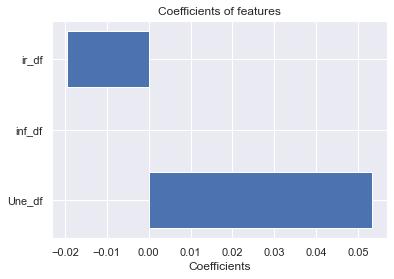

In [97]:
best_coefficients_lasso = search.best_estimator_.named_steps['model'].coef_
feature_names = ctrl_train_lasso.columns
coefs = pd.DataFrame({'feature': feature_names, 'coef': best_coefficients_lasso})
coefs.sort_values('coef', ascending = False, inplace=True)
plt.barh(coefs['feature'],coefs['coef'])
plt.xlabel('Coefficients')
plt.title('Coefficients of features')
plt.show()

#### Determine ARIMA Order

In [98]:
target = diff_train_ARIMA[['EX']]
ctrl = diff_train_ARIMA[['ir_df', 'Une_df']]

In [99]:
ARIMA_order = pm.auto_arima(target, exogenous = ctrl, trace = True, error_action = 'ignore', suppress_warnings = True, 
                      start_p = 0, start_q = 0)
ARIMA_order.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1054.124, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1056.039, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1056.162, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1056.121, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1054.376, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-1054.233, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1052.170, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1058.160, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1056.239, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1056.231, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1058.038, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1054.169, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.739 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  333
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 531.080
Date:                Mon, 13 Mar 2023   AIC                          -1058.160
Time:                        15:25:51   BIC                          -1050.544
Sample:                    03-01-1983   HQIC                         -1055.123
                         - 11-01-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1103      0.040      2.746      0.006       0.032       0.189
sigma2         0.0024      0.000     18.428      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                81.17
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the best model we get is ARIMA(0,1,1).

#### Predict

In [100]:
def arima_model_predict(data, arima_order):
    data = data.astype('float32')
    train_size_temp = int(len(data) * 0.8)
    train_temp_ARIMA, other_temp_ARIMA = data[0 : train_size_temp], data[train_size_temp : ]
    
    train_target_temp = train_temp_ARIMA[['EX']]
    train_ctrl_temp = train_temp_ARIMA[['ir_df', 'Une_df']]
    other_target_temp = other_temp_ARIMA[['EX']]
    other_ctrl_temp = other_temp_ARIMA[['ir_df', 'Une_df']]
    
    history_target = train_target_temp.values.tolist()
    history_ctrl = [x for x in train_ctrl_temp.values]


    predictions = list()
    low = list()
    up = list()

    for t in range(len(other_temp_ARIMA)):
        model_temp = ARIMA(endog = history_target, exog = history_ctrl, order = arima_order).fit()
        forecast = model_temp.get_forecast(steps=1, exog=[other_ctrl_temp.values[t]],alpha = 0.01)
        yhat = forecast.predicted_mean[0]
        conf_int = forecast.conf_int(alpha=0.01)[0]
        predictions.append(yhat)
        low.append(conf_int[0])
        up.append(conf_int[1])
    
        history_target.append(other_target_temp.values[t])
        history_ctrl.append(other_ctrl_temp.values[t])
        
    test_temp = pd.DataFrame(other_target_temp.values, index = other_target_temp.index, columns = ['EX'])
    test_temp['predictions'] = predictions
    test_temp['lower'] = low
    test_temp['upper'] = up
    test_temp.index
    return test_temp

In [101]:
arima_model_predict(train_ARIMA, (0,1,1))

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,EX,predictions,lower,upper
2005-05-01,1.8231,1.913125,1.787091,2.039160
2005-06-01,1.7930,1.815762,1.689169,1.942356
2005-07-01,1.7593,1.792758,1.666351,1.919165
2005-08-01,1.8012,1.757304,1.631018,1.883589
2005-09-01,1.7696,1.803309,1.677075,1.929542
...,...,...,...,...
2010-07-01,1.5714,1.500390,1.374065,1.626715
2010-08-01,1.5358,1.580913,1.454381,1.707445
2010-09-01,1.5731,1.532764,1.406262,1.659265
2010-10-01,1.6020,1.575480,1.449039,1.701922


#### Trading Strategy
---


In [102]:
def trading_strategy_ARIMA(data, w, z, i):
    temp_ARIMA = arima_model_predict(data, (0,1,1)).copy()

    temp_ARIMA['std'] = temp_ARIMA['EX'].rolling(int(w)).std()
    temp_ARIMA['test'] = np.where(temp_ARIMA['predictions'] > temp_ARIMA['EX'].shift()+z*temp_ARIMA['std'].shift(), 1,
                                  np.where(temp_ARIMA['predictions'] < temp_ARIMA['EX'].shift()-z*temp_ARIMA['std'].shift(), -1, 0))
    temp_ARIMA['test'] = temp_ARIMA['test'].shift(-1).fillna(0)

    drange_end = (temp_ARIMA.index[-1] + pd.DateOffset(months = ((i-1)//30 + 1))).strftime('%m/%d/%Y')
    drange = pd.date_range(start = temp_ARIMA.index[0], end = drange_end)
    temp_ARIMA_daily = pd.DataFrame(index = drange)
    temp_ARIMA_daily[['EX', 'predictions', 'test']] = temp_ARIMA[['EX', 'predictions', 'test']]
    temp_ARIMA_daily[['EX', 'predictions']]= temp_ARIMA_daily[['EX', 'predictions']].ffill()
    temp_ARIMA_daily.fillna(0, inplace = True)

    temp_ARIMA_daily.loc[:, str(i) + '_signal'] = 0
    for j in temp_ARIMA_daily.index:
        if temp_ARIMA_daily.loc[j, 'test'] != 0:
            temp_ARIMA_daily.loc[j : j + pd.Timedelta(days = i),str(i) + '_signal'] = temp_ARIMA_daily.loc[j,'test']

    temp_ARIMA_daily['returns'] = np.log(temp_ARIMA_daily['EX']).diff()
    temp_ARIMA_daily[str(i) + '_Return'] = np.exp((temp_ARIMA_daily[str(i) + '_signal'].shift() * temp_ARIMA_daily.returns).cumsum()) - 1

    return temp_ARIMA_daily[str(i) + '_Return'][-1], temp_ARIMA_daily

In [103]:
trading_strategy_ARIMA(train_ARIMA, w=10, z=0.01, i=30,)[0]

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.4304260313103121

In [104]:
a = trading_strategy_ARIMA(train_ARIMA, w=10, z=0.01, i=40,)[1]

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [105]:
a.tail()

,EX,predictions,test,40_signal,returns,40_Return
2010-12-28,1.5578,1.602985,0.0,0,0.0,0.430426
2010-12-29,1.5578,1.602985,0.0,0,0.0,0.430426
2010-12-30,1.5578,1.602985,0.0,0,0.0,0.430426
2010-12-31,1.5578,1.602985,0.0,0,0.0,0.430426
2011-01-01,1.5578,1.602985,0.0,0,0.0,0.430426


#### Optimize

In [106]:
import itertools
w_values = np.arange(0, 20, 5)
z_values = np.arange(0, 0.05, .01)
i_values = np.arange(20, 130, 30) # 感觉可以不要
grid = list(itertools.product(w_values, z_values, i_values))
storage = pd.DataFrame(columns = ['z','w', 'i', 'profits'])

In [107]:
for w, z, i in grid:
    metric = trading_strategy_ARIMA(train_ARIMA, w, z, i)[0]
    storage = storage.append({'z':z, 'w':w, 'i':i, 'profits':metric}, ignore_index = True)

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mouyihan/opt/anaconda3/lib/python

In [108]:
storage.sort_values(by = 'profits', ascending = False).head()

,z,w,i,profits
23,0.0,5.0,110.0,0.570248
22,0.0,5.0,80.0,0.570248
21,0.0,5.0,50.0,0.570248
61,0.0,15.0,50.0,0.545978
63,0.0,15.0,110.0,0.545978


#### Test Strategy

In [109]:
z_best = 0
w_best = 5
i_best = 40
metric_test_ARIMA, test_ARIMA_daily  = trading_strategy_ARIMA(test_ARIMA, w = w_best, z = z_best, i = i_best)
metric_test_ARIMA

0.02390522961592878

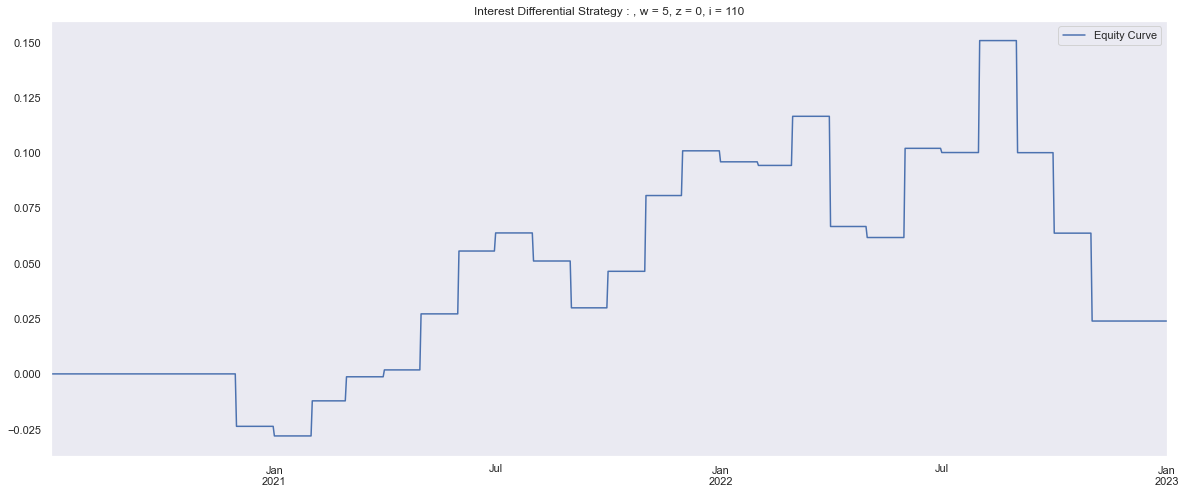

In [110]:
plt.figure(figsize = (20,8))
(test_ARIMA_daily[str(i_best) + '_Return'].dropna()).plot()
plt.title('Interest Differential Strategy : ' + ', w = ' + str(w_best) + ', z = ' + str(z_best)+ ', i = ' + str(i))
plt.legend(['Equity Curve'])
plt.grid()

#### Metrics: myh

In [225]:
test_ARIMA_daily

,EX,predictions,test,40_signal,returns,40_Return,strategy_Returns
2020-07-01,1.3133,1.243340,0.0,0,NaN,NaN,NaN
2020-07-02,1.3133,1.243340,0.0,0,0.0,0.000000,0.0
2020-07-03,1.3133,1.243340,0.0,0,0.0,0.000000,0.0
2020-07-04,1.3133,1.243340,0.0,0,0.0,0.000000,0.0
2020-07-05,1.3133,1.243340,0.0,0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
2022-12-28,1.1962,1.129879,0.0,0,0.0,0.023905,0.0
2022-12-29,1.1962,1.129879,0.0,0,0.0,0.023905,0.0
2022-12-30,1.1962,1.129879,0.0,0,0.0,0.023905,0.0
2022-12-31,1.1962,1.129879,0.0,0,0.0,0.023905,0.0


In [226]:
test_ARIMA_daily['strategy_Returns'] = np.exp(test_ARIMA_daily['40_signal'].shift() * test_ARIMA_daily.returns) - 1
result2 = test_ARIMA_daily[['strategy_Returns', '40_Return']]
result2

,strategy_Returns,40_Return
2020-07-01,NaN,NaN
2020-07-02,0.0,0.000000
2020-07-03,0.0,0.000000
2020-07-04,0.0,0.000000
2020-07-05,0.0,0.000000
...,...,...
2022-12-28,0.0,0.023905
2022-12-29,0.0,0.023905
2022-12-30,0.0,0.023905
2022-12-31,0.0,0.023905


In [227]:
monthly_Returns2 = result2.strategy_Returns.resample('M').apply(lambda x: (1+x).prod() - 1).mul(100)
monthly_Returns2 = monthly_Returns2.to_frame()

In [228]:
monthly_Returns2

,strategy_Returns
2020-07-31,0.000000
2020-08-31,0.000000
2020-09-30,0.000000
2020-10-31,0.000000
2020-11-30,0.000000
2020-12-31,-2.371544
2021-01-31,-0.444512
2021-02-28,1.632297
2021-03-31,1.101849
2021-04-30,0.311707


In [229]:
GEO_Monthly_Returns2 = (1 + monthly_Returns2/100).prod()**(1/len(monthly_Returns2)) - 1

print("GEO Average Monthly Returns: {:.2%}".format(GEO_Monthly_Returns2.item()))
print("High Month: {:.2}%".format(monthly_Returns2.max().item()))
print("Low Month: {:.2}%".format(monthly_Returns2.min().item()))

GEO Average Monthly Returns: 0.08%
High Month: 4.6%
Low Month: -4.5%


In [230]:
std_Deviation_daily2 = result2.strategy_Returns.std()
std_Deviation_monthly2 = monthly_Returns2.strategy_Returns.std()
print("Daily Standard Deviation: {:.2%}".format(std_Deviation_daily2))
print("Monthly Standard Deviation: {:.2}%".format(std_Deviation_monthly2))

Daily Standard Deviation: 0.41%
Monthly Standard Deviation: 2.2%


In [231]:
P2 = 10000
A2 = ((result2['40_Return'] + 1) * P2 )[-1]
t2 = (len(result2)/365)
Returns_Annualized2 = ((A2/P2)**(1/t2) - 1)
std_Annualized2 = std_Deviation_daily2 * np.sqrt(365)
print("Annualized Return: {:.2%}".format(Returns_Annualized2))
print("Annualized STD: {:.2%}".format(std_Annualized2))

Annualized Return: 0.95%
Annualized STD: 7.77%


In [232]:
rf_rate2 = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()
monthly_Returns2['rf'] = rf_rate2
monthly_Returns2['rf'] = monthly_Returns2['rf'].ffill()

rfs2 = monthly_Returns2['rf'].resample("Y").first()[1:-1]
t2 = len(rfs2)
rf_Annualized2 = ((((rfs2/100)+1).cumprod()[-1])**(1/t2)-1)
print("Annualized Risk Free Rate: {:.2%}".format(rf_Annualized2))

Annualized Risk Free Rate: 0.44%


In [233]:
# Monthly
Return_frame2 = monthly_Returns2[['strategy_Returns']].copy().dropna()
Return_frame2['rf'] = (monthly_Returns2[['rf']].dropna()/100 + 1) ** (1/12) - 1
Return_frame2['strategy_Returns']=Return_frame2['strategy_Returns']/100

arima_yr = (Return_frame2 + 1).resample('Y').prod() - 1
arima_yr['excess'] = arima_yr['strategy_Returns'] - arima_yr['rf']

annualized_reY_arima = (arima_yr['excess'] + 1).prod()**(1/len(arima_yr)) - 1
std_reY_arima = arima_yr['excess'].std()

sharpe_arima = annualized_reY_arima/std_reY_arima

print("Sharpe Ratio: {:.2}".format(sharpe_arima))

Sharpe Ratio: -0.035


In [234]:
monthly_Returns2['win'] = (monthly_Returns2['strategy_Returns'] > 0).astype(int)

In [235]:
Winning_Mo2 = monthly_Returns2['win'].sum() / len(monthly_Returns2)
print("The % of Winning Month: {:.2%}".format(Winning_Mo2))

The % of Winning Month: 38.71%


In [236]:
P = 10000
monthly_Returns2['Value'] = P * ((1 + monthly_Returns2['strategy_Returns']/100).cumprod())

drawdown2 = (monthly_Returns2['Value'] - monthly_Returns2['Value'].cummax()) / monthly_Returns2['Value'].cummax()
Max_Drawdown2 = drawdown2.min()
print("Max Drawdown: {:.2%}".format(- Max_Drawdown2))

Max Drawdown: 11.02%


In [237]:
market = yf.download(['^GSPC'])['Adj Close']
market.index = market.index.tz_localize(None)
market = (market.resample('M').last().pct_change()).to_frame().rename(columns = {'Adj Close':'market_Returns'})

[*********************100%***********************]  1 of 1 completed


In [238]:
Return_frame2['market_Returns'] = market

Return_frame2

,strategy_Returns,rf,market_Returns
2020-07-31,0.000000,0.000092,0.055101
2020-08-31,0.000000,0.000100,0.070065
2020-09-30,0.000000,0.000100,-0.039228
2020-10-31,0.000000,0.000100,-0.027666
2020-11-30,0.000000,0.000092,0.107546
2020-12-31,-0.023715,0.000083,0.037121
2021-01-31,-0.004445,0.000083,-0.011137
2021-02-28,0.016323,0.000083,0.026091
2021-03-31,0.011018,0.000058,0.042439
2021-04-30,0.003117,0.000042,0.052425


In [239]:
Return_frame2['ex'] = Return_frame2['strategy_Returns'] - Return_frame2['rf']
Return_frame2['ex_m'] = Return_frame2['market_Returns'] - Return_frame2['rf']
model2 = smf.ols(formula = 'ex ~ ex_m', data = Return_frame2).fit()
corr2 = Return_frame2['ex'].corr(Return_frame2['ex_m'])
print("Alpha: {:.2}".format(model2.params[0]), "Beta: {:.2}".format(model2.params[1]))
print("R-Squared: {:.1}".format(model2.rsquared))
print("Correlation: {:.2}".format(corr2))

Alpha: -0.00037 Beta: 0.031
R-Squared: 0.006
Correlation: 0.075


In [240]:
# Store the alpha and beta
alpha_ar = model2.params[0]
beta_ar = model2.params[1]
R2_ar = model2.rsquared


In [241]:
up2 = Return_frame2[Return_frame2.market_Returns > 0]
ols_up2 = smf.ols(formula = 'ex ~ ex_m', data = up2).fit()
ols_up2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ex   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.703
Date:                Mon, 13 Mar 2023   Prob (F-statistic):              0.209
Time:                        17:28:18   Log-Likelihood:                 49.566
No. Observations:                  19   AIC:                            -95.13
Df Residuals:                      17   BIC:                            -93.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0106      0.009      1.225      0.237      -0.008       0.029
ex_m          -0.2089      0.160     -1.305      0.209      -0.547       0.129
==============================================================================
Omnibus:                        3.514   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.621
Skew:                          -0.899   Prob(JB):                        0.270
Kurtosis:                       2.725   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [201]:
up_alpha_ar = ols_up2.params[0]
up_beta_ar = ols_up2.params[1]
up_R2_ar = ols_up2.rsquared

In [203]:
down2 = Return_frame2[Return_frame2.market_Returns < 0]
ols_down2 = smf.ols(formula = 'ex ~ ex_m', data = down2).fit()
ols_down2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ex   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2.448
Date:                Mon, 13 Mar 2023   Prob (F-statistic):              0.149
Time:                        17:16:19   Log-Likelihood:                 27.459
No. Observations:                  12   AIC:                            -50.92
Df Residuals:                      10   BIC:                            -49.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0202      0.016      1.270      0.233      -0.015       0.056
ex_m           0.4342      0.277      1.565      0.149      -0.184       1.052
==============================================================================
Omnibus:                        3.585   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                1.970
Skew:                           0.990   Prob(JB):                        0.373
Kurtosis:                       2.874   Cond. No.                         35.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [204]:
# Store the alpha and beta and r2
down_alpha_ar = ols_down2.params[0]
down_beta_ar = ols_down2.params[1]
down_R2_ar = ols_down2.rsquared

In [217]:
Metric_RiskReturn2 = ['Geo.Average Monthly', 'Std.Deviation', 'High Month', 'Low Month',
                     'Annualized Return', 'Annualized STD',
                     'Risk Free Rate', 'Sharp Ratio', '% of Winning Mo.', 'Max Drawdown']
Values_RiskReturn_arima = [GEO_Monthly_Returns2.item()*100,std_Deviation_monthly2,monthly_Returns2.max().item(),monthly_Returns2.min().item(),Returns_Annualized2*100,std_Annualized2*100,rf_Annualized2*100,sharpe_arima,Winning_Mo2*100,(-Max_Drawdown2)*100]

Metric_Regression2 = ['Alpha', 'Beta', 'Mnt.R-Squared', 'Correlation',
                     'Up Alpha', 'Up Beta', 'Up R-Squared',
                     'Down Alpha', 'Down Beta', 'Down R-Squared']
Values_Regression_arima = [alpha_ar,beta_ar,R2_ar, corr2, up_alpha_ar,up_beta_ar,up_R2_ar,down_alpha_ar,down_beta_ar,down_R2_ar]
HFRI_KF2 = pd.DataFrame({'Metric_RR': Metric_RiskReturn2, 'Value_RR': Values_RiskReturn_arima,
                        'Metric_R': Metric_Regression2, 'Value_R': Values_Regression_arima})

In [218]:
HFRI_KF2

,Metric_RR,Value_RR,Metric_R,Value_R
0,Geo.Average Monthly,0.076235,Alpha,-0.000371
1,Std.Deviation,2.242445,Beta,0.031003
2,High Month,4.602040,Mnt.R-Squared,0.005644
3,Low Month,-4.463198,Correlation,0.075123
4,Annualized Return,0.946831,Up Alpha,0.010580
5,Annualized STD,7.773734,Up Beta,-0.208934
6,Risk Free Rate,0.439425,Up R-Squared,0.091076
7,Sharp Ratio,-0.034859,Down Alpha,0.020197
8,% of Winning Mo.,38.709677,Down Beta,0.434156
9,Max Drawdown,11.021613,Down R-Squared,0.196650


---

#### Other: Test Strategy_noz
---
If we don't tune z,w, and i

In [111]:
def trading_strategy_ARIMA_noz(data):
    temp_ARIMA_noz = arima_model_predict(data, (0,1,1)).copy()

    temp_ARIMA_noz['test'] = np.where(temp_ARIMA_noz['predictions'] > temp_ARIMA_noz['EX'].shift(), 1, -1)
    temp_ARIMA_noz['test'] = temp_ARIMA_noz['test'].shift(-1).fillna(0)
    temp_ARIMA_noz['returns'] = np.log(temp_ARIMA_noz['EX'] / temp_ARIMA_noz['EX'].shift())
    temp_ARIMA_noz['strategy Returns'] = np.exp((temp_ARIMA_noz['test'].shift() * temp_ARIMA_noz.returns).cumsum()) - 1
    return temp_ARIMA_noz['strategy Returns'][-1], temp_ARIMA_noz

In [112]:
metric_test_ARIMA_noz, test_ARIMA_noz = trading_strategy_ARIMA_noz(test_ARIMA)
metric_test_ARIMA_noz

0.03988788094534845

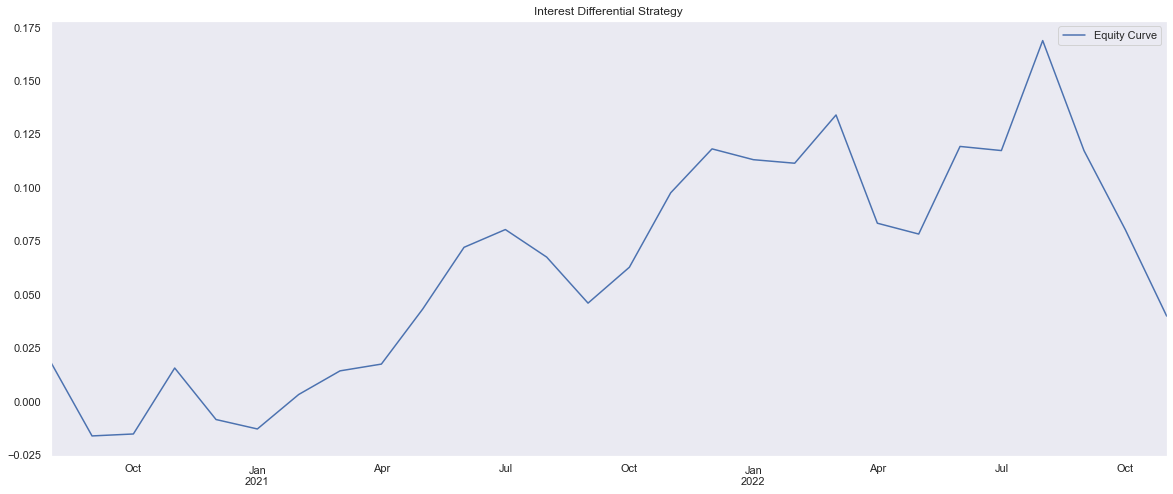

In [113]:
plt.figure(figsize = (20,8))
(test_ARIMA_noz['strategy Returns'].dropna()).plot()
plt.title('Interest Differential Strategy')
plt.legend(['Equity Curve'])
plt.grid()